# Appendix A: Demonstration of the Stop-Move-Noise (MSN) classification method

Import packages and general settings:

In [18]:
import os
import sys
sys.path.insert(0, os.path.pardir)

from msn import msn, util
from msn import preprocessing as pp
from msn import stats as st

import math
import numpy as np
from scipy import stats
import pandas as pd

import gpxpy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

matplotlib.rcParams['axes.labelsize'] = '10'
matplotlib.rcParams['ytick.labelsize'] = '10'
matplotlib.rcParams['xtick.labelsize'] = '10'
matplotlib.rcParams['axes.titlesize'] = '10'
matplotlib.rcParams['legend.edgecolor'] = 'k'
matplotlib.rcParams['legend.shadow'] = True
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['figure.figsize'] = (7, 5)
sns.set_style('ticks', {"axes.xmargin": 0.2, "axes.ymargin": 0.2});

# For pretty printing
import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
column_names = ['timestamp', 'line_id', 'direction', 'journey_pattern_id', 'time_frame',
                'vehicle_journey_id', 'operator', 'congestion', 'lon', 'lat', 'delay',
                'block_id', 'vehicle_id', 'stop_id', 'at_stop']
run = pd.read_csv('~/Downloads/13902_122_modified.csv', header=0, names=column_names)

run['timestamp'] = pd.to_datetime(run.timestamp)
len(run)

1025

In [3]:
run.drop_duplicates(subset=['lon', 'lat'], keep='last', inplace=True)
len(run)

674

In [4]:
# adapt dataframe to MSN
gpx = pp.dublin_bus_to_gpx(run)
print(gpx.get_points_no())
df = pp.compute_attributes(gpx)
len(df)

674


566

Compute movement attributes:

In [5]:
df = pp.compute_attributes(gpx)[1:]

# first 5 rows:
df.head()
np.median(df.distance)

23.47

Plot the trajectory:

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

xx = df.longitude
yy = df.latitude

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.plot(df.longitude, df.latitude, 'o:', ms=7)

central_latitude = sum(plt.axes().get_ylim())/2.
mercator_aspect_ratio = 1/math.cos(math.radians(central_latitude))
plt.axes().set_aspect(mercator_aspect_ratio, adjustable='datalim')
plt.tight_layout()

Relationship among distance, duration, and speed between each pair of sequential points:

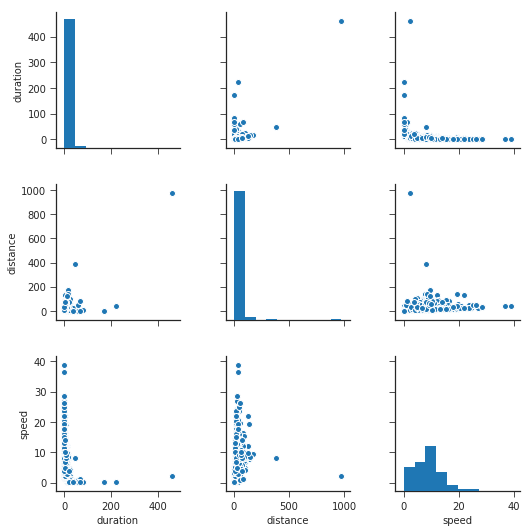

In [7]:
sns.pairplot(df[['duration', 'distance', 'speed']]);
plt.tight_layout()

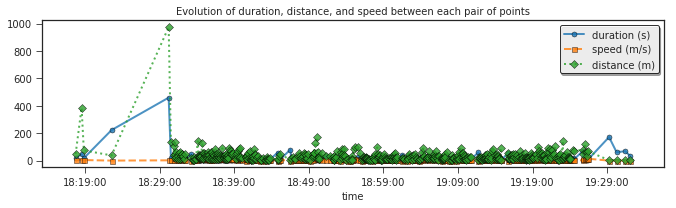

In [8]:
fig = plt.figure(figsize=(9.5,3))
plt.title('Evolution of duration, distance, and speed between each pair of points')
plt.plot(df['duration'], '-o', label='duration (s)', lw=2, ms=5, mew=.5, mec='k', alpha=.8)
plt.plot(df['speed'], '--s', label='speed (m/s)', lw=2, ms=5, mew=.5, mec='k', alpha=.8)
plt.plot(df['distance'], ':D', label='distance (m)', lw=2, ms=5, mew=.5, mec='k', alpha=.8)

plt.gca().xaxis.zoom(-0.1)
plt.xlabel("time")

plt.legend(loc='best', frameon=True);
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.tight_layout()

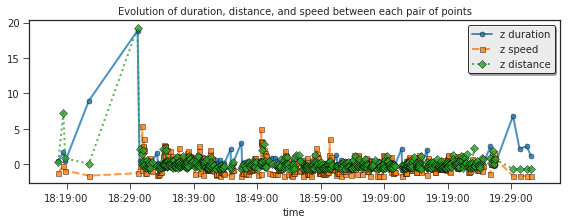

In [9]:
df['z_duration'] = stats.zscore(df['duration'])
df['z_speed'] = stats.zscore(df['speed'])
df['z_distance'] = stats.zscore(df['distance'])

fig = plt.figure(figsize=(9.5,3))
plt.title('Evolution of duration, distance, and speed between each pair of points')
plt.plot(df['z_duration'], '-o', label='z duration', lw=2, ms=5, mew=.5, mec='k', alpha=.8)
plt.plot(df['z_speed'], '--s', label='z speed', lw=2, ms=5, mew=.5, mec='k', alpha=.8)
plt.plot(df['z_distance'], ':D', label='z distance', lw=2, ms=5, mew=.5, mec='k', alpha=.8)

plt.gca().xaxis.zoom(-0.1)
plt.xlabel("time")

plt.legend(loc='best', frameon=True);
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
#plt.tight_layout()

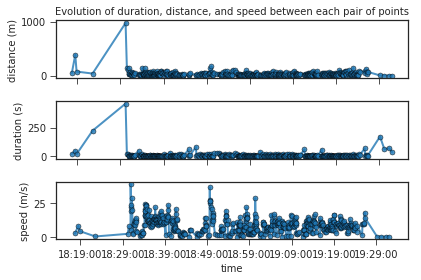

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
ax1.set_title('Evolution of duration, distance, and speed between each pair of points')
ax1.plot(df['distance'], '-o', label='distance (m)', lw=2, ms=5, mew=.5, mec='k', alpha=.8)
ax1.set_ylabel('distance (m)')

ax2.plot(df['duration'], '-o', label='duration (s)', lw=2, ms=5, mew=.5, mec='k', alpha=.8)
ax2.set_ylabel('duration (s)')

ax3.plot(df['speed'], '-o', label='speed (m/s)', lw=2, ms=5, mew=.5, mec='k', alpha=.8)
ax3.set_ylabel('speed (m/s)')

plt.gca().xaxis.zoom(-0.1)
plt.xlabel("time")

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.tight_layout()

## Parameters

- `distance_threshold`, `duration_threshold`, `speed_threshold`: value of absolute modified z-score at which higher values are considered as outliers

- `minimum_angle`: minimum angle in degrees

- `max_sequential_sharp_angles`: maximum number of sequential angles that can be below `minimum_angle`

- `jitter`: amount of random noise that can be added to each duration

In [11]:
distance_threshold = 3.5
duration_threshold = 5.0
speed_threshold = 3.5

minimum_angle = 45
max_sequential_sharp_angles = 1

jitter = 0.01

## Noise labeling

### Analysis of distance between points

Statistics about distance:

In [12]:
df['distance'].describe()

count    565.000000
mean      32.925080
std       48.924269
min        1.130000
25%       14.660000
50%       23.470000
75%       39.610000
max      975.230000
Name: distance, dtype: float64

Modified z-score computation:

In [13]:
mz_distance = st.modified_zscore(df['distance'])
long_distance_indexes = [i for i, mz in enumerate(mz_distance) 
                         if mz > distance_threshold]

Abnormal distance(s):

In [14]:
df.iloc[long_distance_indexes]

latitude  longitude  distance  duration  speed  \
2012-11-25 18:18:30.000000  53.365417  -6.309810    386.31        48   8.05   
2012-11-25 18:30:11.000000  53.373547  -6.311382    975.23       460   2.12   
2012-11-25 18:30:29.000000  53.373581  -6.313452    137.34        18   7.63   
2012-11-25 18:31:00.216916  53.373516  -6.314487    135.65         7  19.38   
2012-11-25 18:34:06.232734  53.367194  -6.315447    141.03        17   8.30   
2012-11-25 18:34:42.780975  53.365224  -6.309231    132.21        11  12.02   
2012-11-25 18:49:49.000000  53.353207  -6.268034    131.83         6  21.97   
2012-11-25 18:50:07.017387  53.353576  -6.265530    171.08        18   9.50   
2012-11-25 19:23:04.000000  53.330963  -6.319819    142.99        17   8.41   
2012-11-25 19:26:02.104245  53.326315  -6.322015    124.82        13   9.60   

                            acceleration  heading   angle  elevation  \
2012-11-25 18:18:30.000000         -0.22      119  179.20         44   
2012-11-25 18:30:11.000000          0.31      348  103.72         37   
2012-11-25 18:30:29.000000         -0.13      272    2.06         41   
2012-11-25 18:31:00.216916          2.85      264  101.61         42   
2012-11-25 18:34:06.232734          0.07      110  178.80         46   
2012-11-25 18:34:42.780975          0.50      119  179.35         44   
2012-11-25 18:49:49.000000         -0.69      213   42.70         15   
2012-11-25 18:50:07.017387         10.69       76  156.21         18   
2012-11-25 19:23:04.000000          0.02      231  175.07         34   
2012-11-25 19:26:02.104245         -0.07      158  179.81         43   

                                            timestamp  idx  z_duration  \
2012-11-25 18:18:30.000000 2012-11-25 18:18:30.000000    2    1.689847   
2012-11-25 18:30:11.000000 2012-11-25 18:30:11.000000    5   18.864999   
2012-11-25 18:30:29.000000 2012-11-25 18:30:29.000000    6    0.439229   
2012-11-25 18:31:00.216916 2012-11-25 18:31:00.216916    9   -0.019331   
2012-11-25 18:34:06.232734 2012-11-25 18:34:06.232734   35    0.397542   
2012-11-25 18:34:42.780975 2012-11-25 18:34:42.780975   48    0.147418   
2012-11-25 18:49:49.000000 2012-11-25 18:49:49.000000  197   -0.061018   
2012-11-25 18:50:07.017387 2012-11-25 18:50:07.017387  198    0.439229   
2012-11-25 19:23:04.000000 2012-11-25 19:23:04.000000  538    0.397542   
2012-11-25 19:26:02.104245 2012-11-25 19:26:02.104245  557    0.230792   

                             z_speed  z_distance  
2012-11-25 18:18:30.000000 -0.152724    7.229501  
2012-11-25 18:30:11.000000 -1.227398   19.277548  
2012-11-25 18:30:29.000000 -0.228840    2.136106  
2012-11-25 18:31:00.216916  1.900573    2.101533  
2012-11-25 18:34:06.232734 -0.107418    2.211596  
2012-11-25 18:34:42.780975  0.566745    2.031158  
2012-11-25 18:49:49.000000  2.369950    2.023384  
2012-11-25 18:50:07.017387  0.110054    2.826355  
2012-11-25 19:23:04.000000 -0.087483    2.251693  
2012-11-25 19:26:02.104245  0.128177    1.879974

Distribution of modified-zscore of distances:

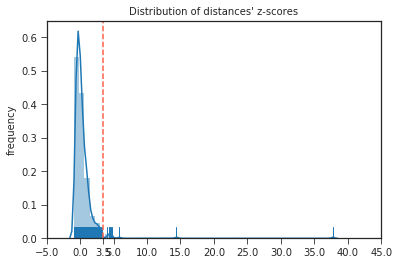

In [15]:
plt.figure()
plt.title("Distribution of distances' z-scores")
plt.ylabel('frequency')

sns.distplot(mz_distance.as_matrix(), rug=True)

plt.xticks(list(plt.xticks()[0]) + [distance_threshold])
plt.axvline(distance_threshold, color='tomato', linestyle='--');

### Analysis of angles between points

In [19]:
sharp_angles = df[df['angle'] < minimum_angle][:-1]
sharp_angles_index = [df.index.get_loc(i) 
                          for i in sharp_angles.index]

diff = np.ediff1d(sharp_angles_index, np.inf)
mask = [True if d <= max_sequential_sharp_angles + 1 
            else False for d in diff]

outliers = []
for i, m in enumerate(mask):
    if m:
        outliers.append(sharp_angles_index[i])
        #outliers.append(sharp_angles_index[i+1])
        
sharp_angle_intervals = util.get_interval_limits(outliers)

sharp_angle_indexes = []
for interval in sharp_angle_intervals:
    sharp_angle_indexes.extend(np.linspace(interval[0], 
                                           interval[1], 
                                           interval[1]-interval[0]+1, 
                                           dtype=int))

Sharp angles:

In [20]:
df.iloc[sharp_angle_indexes]

latitude  longitude  distance  duration  speed  \
2012-11-25 18:30:29  53.373581  -6.313452    137.34        18   7.63   
2012-11-25 18:57:09  53.348701  -6.251483      4.56         3   1.52   

                     acceleration  heading  angle  elevation  \
2012-11-25 18:30:29         -0.13      272   2.06         41   
2012-11-25 18:57:09         -0.07      158  11.00          9   

                              timestamp  idx  z_duration   z_speed  z_distance  
2012-11-25 18:30:29 2012-11-25 18:30:29    6    0.439229 -0.228840    2.136106  
2012-11-25 18:57:09 2012-11-25 18:57:09  256   -0.186080 -1.336134   -0.580289

In [21]:
plt.figure()

plt.title('Evolution of direction')
plt.ylabel('Angle (degrees)')

plt.plot(df['angle'][:-1], ':o')
plt.plot(df.iloc[sharp_angle_indexes]['angle'], 's', color='tomato')
plt.axhline(minimum_angle, color='tomato', ls='--')
plt.gca().xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter("%H:%M:%S"));

FigureCanvasNbAgg()

### Remove outliers

In [22]:
noise_indexes = np.union1d(long_distance_indexes, sharp_angle_indexes)
noise_indexes = np.array(noise_indexes, dtype=int)
noise_intervals = util.get_interval_limits(noise_indexes)

noise_indexes = np.array([])
for interval in noise_intervals:
    linspace = np.linspace(interval[0], interval[1], interval[1]-interval[0]+1)
    noise_indexes = np.concatenate((noise_indexes, linspace))
    
noise_indexes = np.array(np.sort(noise_indexes), dtype=int)
noise = df.iloc[noise_indexes]

df_clean = df.drop(df.index[noise_indexes])

original_len = len(df)
without_outliers_len = len(df_clean)

print('original:', original_len)
print('without outliers:', without_outliers_len)
print('{:.2f}% of points have been dropped'.format((1 - without_outliers_len/original_len)*100))

original: 565
without outliers: 555
1.77% of points have been dropped


Show noisy points:

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Noise points')

xx = df.longitude
yy = df.latitude
plt.plot(xx, yy, 'o:', ms=7, alpha=1)

xx = df.iloc[noise_indexes].longitude
yy = df.iloc[noise_indexes].latitude
plt.plot(xx, yy, 's', ms=9, alpha=.8, mew=.5, mec='k')

central_latitude = sum(plt.axes().get_ylim())/2.
mercator_aspect_ratio = 1/math.cos(math.radians(central_latitude))
plt.axes().set_aspect(mercator_aspect_ratio, adjustable='datalim')

FigureCanvasNbAgg()

## Stop classification

### Analysis of duration between points

Statistics about duration:

In [24]:
df_clean['duration'].describe()

count    555.000000
mean       6.508108
std       14.578353
min        1.000000
25%        2.000000
50%        3.000000
75%        6.000000
max      223.000000
Name: duration, dtype: float64

Modified z-score computation:

In [25]:
duration_with_jitter = pp.jitter(df_clean['duration'], jitter)
mz_duration = st.modified_zscore(duration_with_jitter)
long_duration_indexes = [i for i, mz in enumerate(mz_duration) if mz > duration_threshold]

Abnormal duration(s):

In [26]:
df_clean.iloc[long_duration_indexes]

latitude  longitude  distance  duration  speed  \
2012-11-25 18:22:31.000000  53.364967  -6.308289     38.05       223   0.17   
2012-11-25 18:33:11.000000  53.368092  -6.317942     21.78        46   0.47   
2012-11-25 18:40:30.000000  53.360809  -6.276051     23.77        32   0.74   
2012-11-25 18:44:49.000000  53.360115  -6.263700      1.99        59   0.03   
2012-11-25 18:46:31.000000  53.359959  -6.262219      4.90        81   0.06   
2012-11-25 18:51:20.678638  53.353417  -6.262226     34.48        31   1.11   
2012-11-25 18:51:50.409877  53.353179  -6.261946     32.51        29   1.12   
2012-11-25 19:01:29.000000  53.344296  -6.260611     19.91        39   0.51   
2012-11-25 19:11:43.000000  53.332214  -6.274559      7.70        60   0.13   
2012-11-25 19:15:45.250205  53.333285  -6.291059     52.53        58   0.91   
2012-11-25 19:25:43.000000  53.327736  -6.322989     78.04        69   1.13   
2012-11-25 19:29:16.000000  53.324982  -6.320100      2.87       172   0.02   
2012-11-25 19:30:17.000000  53.324982  -6.320083      1.13        61   0.02   
2012-11-25 19:31:26.000000  53.324966  -6.320083      1.78        69   0.03   
2012-11-25 19:32:03.000000  53.324966  -6.320100      1.13        37   0.03   

                            acceleration  heading   angle  elevation  \
2012-11-25 18:22:31.000000          0.00      111   56.98         43   
2012-11-25 18:33:11.000000          0.05      205  167.26         48   
2012-11-25 18:40:30.000000          3.61       87  172.18         31   
2012-11-25 18:44:49.000000          1.63       90  166.96         16   
2012-11-25 18:46:31.000000          0.43       99  171.13         13   
2012-11-25 18:51:20.678638          0.00      141  175.78         14   
2012-11-25 18:51:50.409877          0.00      145  178.05         10   
2012-11-25 19:01:29.000000          0.24      265  172.74         12   
2012-11-25 19:11:43.000000          1.01      268  174.82         19   
2012-11-25 19:15:45.250205         10.52      310  171.19         22   
2012-11-25 19:25:43.000000          1.61      162  175.29         40   
2012-11-25 19:29:16.000000          0.00      308   38.23         48   
2012-11-25 19:30:17.000000          0.00       90   90.00         48   
2012-11-25 19:31:26.000000          0.00      180   90.00         48   
2012-11-25 19:32:03.000000          0.00      270    0.00         48   

                                            timestamp  idx  z_duration  \
2012-11-25 18:22:31.000000 2012-11-25 18:22:31.000000    4    8.985118   
2012-11-25 18:33:11.000000 2012-11-25 18:33:11.000000   28    1.606472   
2012-11-25 18:40:30.000000 2012-11-25 18:40:30.000000  130    1.022850   
2012-11-25 18:44:49.000000 2012-11-25 18:44:49.000000  167    2.148407   
2012-11-25 18:46:31.000000 2012-11-25 18:46:31.000000  171    3.065526   
2012-11-25 18:51:20.678638 2012-11-25 18:51:20.678638  207    0.981163   
2012-11-25 18:51:50.409877 2012-11-25 18:51:50.409877  208    0.897789   
2012-11-25 19:01:29.000000 2012-11-25 19:01:29.000000  304    1.314661   
2012-11-25 19:11:43.000000 2012-11-25 19:11:43.000000  403    2.190094   
2012-11-25 19:15:45.250205 2012-11-25 19:15:45.250205  447    2.106719   
2012-11-25 19:25:43.000000 2012-11-25 19:25:43.000000  555    2.565279   
2012-11-25 19:29:16.000000 2012-11-25 19:29:16.000000  562    6.859067   
2012-11-25 19:30:17.000000 2012-11-25 19:30:17.000000  563    2.231781   
2012-11-25 19:31:26.000000 2012-11-25 19:31:26.000000  564    2.565279   
2012-11-25 19:32:03.000000 2012-11-25 19:32:03.000000  565    1.231287   

                             z_speed  z_distance  
2012-11-25 18:22:31.000000 -1.580790    0.104845  
2012-11-25 18:33:11.000000 -1.526422   -0.228005  
2012-11-25 18:40:30.000000 -1.477491   -0.187293  
2012-11-25 18:44:49.000000 -1.606162   -0.632866  
2012-11-25 18:46:31.000000 -1.600725   -0.573333  
2012-11-25 18:51:20.678638 -1.410437    0.031810  
2012-11-25 18:51:50.409877 -1.408625   -0.008492  
2012-11-25 19:01:2

Distribution of modified-zscore of durations:

In [27]:
plt.figure()
plt.title("Distribution of durations' z-scores")
plt.ylabel('frequency')

sns.distplot(mz_duration.as_matrix(), rug=True)

plt.xticks(list(plt.xticks()[0]) + [duration_threshold])
plt.axvline(duration_threshold, color='tomato', linestyle='--');

FigureCanvasNbAgg()

### Analysis of speed

Statistics about speed:

In [28]:
df_clean['speed'].describe()

count    555.000000
mean       8.874757
std        5.508209
min        0.020000
25%        4.940000
50%        8.790000
75%       11.520000
max       38.910000
Name: speed, dtype: float64

Modified z-score computation:

In [29]:
mz_speed = st.modified_zscore(np.log(df_clean['speed']))
slow_speed_indexes = [i for i, mz in enumerate(mz_speed) if mz < -3.5]

Abnormal speed(s):

In [30]:
df_clean.iloc[slow_speed_indexes]

latitude  longitude  distance  duration  speed  \
2012-11-25 18:22:31  53.364967  -6.308289     38.05       223   0.17   
2012-11-25 18:42:30  53.360260  -6.265541      8.63        22   0.39   
2012-11-25 18:43:09  53.360226  -6.265137      3.38        21   0.16   
2012-11-25 18:44:49  53.360115  -6.263700      1.99        59   0.03   
2012-11-25 18:46:31  53.359959  -6.262219      4.90        81   0.06   
2012-11-25 18:49:10  53.356197  -6.265108      6.86        20   0.34   
2012-11-25 18:53:10  53.351402  -6.260767      5.35        21   0.25   
2012-11-25 18:54:29  53.352982  -6.256733      2.07        14   0.15   
2012-11-25 18:56:10  53.350266  -6.253950      2.11        21   0.10   
2012-11-25 18:57:29  53.348732  -6.251517      4.12        20   0.21   
2012-11-25 19:02:10  53.344296  -6.261314      2.92        21   0.14   
2012-11-25 19:03:48  53.342400  -6.264585      7.38        19   0.39   
2012-11-25 19:06:48  53.334358  -6.265276      3.00        21   0.14   
2012-11-25 19:07:47  53.333157  -6.262697      4.80        19   0.25   
2012-11-25 19:08:07  53.333111  -6.262680      5.23        20   0.26   
2012-11-25 19:08:46  53.332638  -6.264178      5.00        20   0.25   
2012-11-25 19:11:43  53.332214  -6.274559      7.70        60   0.13   
2012-11-25 19:29:16  53.324982  -6.320100      2.87       172   0.02   
2012-11-25 19:30:17  53.324982  -6.320083      1.13        61   0.02   
2012-11-25 19:31:26  53.324966  -6.320083      1.78        69   0.03   
2012-11-25 19:32:03  53.324966  -6.320100      1.13        37   0.03   

                     acceleration  heading   angle  elevation  \
2012-11-25 18:22:31          0.00      111   56.98         43   
2012-11-25 18:42:30          0.38       93  166.25         20   
2012-11-25 18:43:09          1.39       88  163.90         20   
2012-11-25 18:44:49          1.63       90  166.96         16   
2012-11-25 18:46:31          0.43       99  171.13         13   
2012-11-25 18:49:10          0.06      209  176.63         21   
2012-11-25 18:53:10          2.48      113   47.98         12   
2012-11-25 18:54:29          0.19      329   59.74          8   
2012-11-25 18:56:10         10.85      180  154.54          8   
2012-11-25 18:57:29          0.89      327   34.69          9   
2012-11-25 19:02:10          2.17      270  177.84         13   
2012-11-25 19:03:48          6.54      217  136.91         15   
2012-11-25 19:06:48          5.91      180  177.77         18   
2012-11-25 19:07:47          0.00      166  178.86         19   
2012-11-25 19:08:07          2.64      168  155.44         19   
2012-11-25 19:08:46         16.02      256  176.46         19   
2012-11-25 19:11:43          1.01      268  174.82         19   
2012-11-25 19:29:16          0.00      308   38.23         48   
2012-11-25 19:30:17          0.00       90   90.00         48   
2012-11-25 19:31:26          0.00      180   90.00         48   
2012-11-25 19:32:03          0.00      270    0.00         48   

                              timestamp  idx  z_duration   z_speed  z_distance  
2012-11-25 18:22:31 2012-11-25 18:22:31    4    8.985118 -1.580790    0.104845  
2012-11-25 18:42:30 2012-11-25 18:42:30  155    0.605978 -1.540920   -0.497025  
2012-11-25 18:43:09 2012-11-25 18:43:09  159    0.564291 -1.582603   -0.604429  
2012-11-25 18:44:49 2012-11-25 18:44:49  167    2.148407 -1.606162   -0.632866  
2012-11-25 18:46:31 2012-11-25 18:46:31  171    3.065526 -1.600725   -0.573333  
2012-11-25 18:49:10 2012-11-25 18:49:10  190    0.522603 -1.549982   -0.533236  
2012-11-25 18:53:10 2012-11-25 18:53:10  218    0.564291 -1.566292   -0.564127  
2012-11-25 18:54:29 2012-11-25 18:54:29  230    0.272480 -1.584415   -0.631229  
2012-11-25 18:56:10 2012-11-25 18:56:10  238    0.564291 -1.593476   -0.630411  
2012-11-25 18:57:29 2012-11-25 18:57:29  257    0.522603 -1.573541   -0.589290  
2012-11-25 19:02:10 2012-11-25 19:02:10  308    0.564291 -1.586227   -0.613840  
2012-11-25 19:03:48 2012-11-25 19:

Distribution of modified-zscore of speeds:

In [31]:
plt.figure()
plt.title("Distribution of speed's z-scores")
plt.ylabel('frequency')

sns.distplot(df['speed'].as_matrix(), rug=True)

plt.xticks(list(plt.xticks()[0]) + [-speed_threshold])
plt.axvline(-speed_threshold, color='tomato', linestyle='--');

FigureCanvasNbAgg()

In [32]:
plt.figure()
plt.title("Distribution of speed's log z-scores")
plt.ylabel('frequency')

sns.distplot(mz_speed.as_matrix(), rug=True)

plt.xticks(list(plt.xticks()[0]) + [-speed_threshold])
plt.axvline(-speed_threshold, color='tomato', linestyle='--');

FigureCanvasNbAgg()

### The intersection of long times and slow speed are probably stops

In [33]:
stops = df_clean.iloc[np.intersect1d(long_duration_indexes, slow_speed_indexes)]
stops

latitude  longitude  distance  duration  speed  \
2012-11-25 18:22:31  53.364967  -6.308289     38.05       223   0.17   
2012-11-25 18:44:49  53.360115  -6.263700      1.99        59   0.03   
2012-11-25 18:46:31  53.359959  -6.262219      4.90        81   0.06   
2012-11-25 19:11:43  53.332214  -6.274559      7.70        60   0.13   
2012-11-25 19:29:16  53.324982  -6.320100      2.87       172   0.02   
2012-11-25 19:30:17  53.324982  -6.320083      1.13        61   0.02   
2012-11-25 19:31:26  53.324966  -6.320083      1.78        69   0.03   
2012-11-25 19:32:03  53.324966  -6.320100      1.13        37   0.03   

                     acceleration  heading   angle  elevation  \
2012-11-25 18:22:31          0.00      111   56.98         43   
2012-11-25 18:44:49          1.63       90  166.96         16   
2012-11-25 18:46:31          0.43       99  171.13         13   
2012-11-25 19:11:43          1.01      268  174.82         19   
2012-11-25 19:29:16          0.00      308   38.23         48   
2012-11-25 19:30:17          0.00       90   90.00         48   
2012-11-25 19:31:26          0.00      180   90.00         48   
2012-11-25 19:32:03          0.00      270    0.00         48   

                              timestamp  idx  z_duration   z_speed  z_distance  
2012-11-25 18:22:31 2012-11-25 18:22:31    4    8.985118 -1.580790    0.104845  
2012-11-25 18:44:49 2012-11-25 18:44:49  167    2.148407 -1.606162   -0.632866  
2012-11-25 18:46:31 2012-11-25 18:46:31  171    3.065526 -1.600725   -0.573333  
2012-11-25 19:11:43 2012-11-25 19:11:43  403    2.190094 -1.588039   -0.516051  
2012-11-25 19:29:16 2012-11-25 19:29:16  562    6.859067 -1.607974   -0.614863  
2012-11-25 19:30:17 2012-11-25 19:30:17  563    2.231781 -1.607974   -0.650459  
2012-11-25 19:31:26 2012-11-25 19:31:26  564    2.565279 -1.606162   -0.637162  
2012-11-25 19:32:03 2012-11-25 19:32:03  565    1.231287 -1.606162   -0.650459

### Relation between duration and speed

In [34]:
x_label = 'modified z-score (duration)'
y_label = 'modified z-score (speed)'

x = mz_duration
y = mz_speed
X = np.stack((x, y), axis=-1)

fig = plt.figure()
plt.xlabel(x_label)
plt.ylabel(y_label)
ax = fig.add_subplot(111)
plt.scatter(X[:,0], X[:,1], s=50, alpha=.8, color='cornflowerblue', lw=1)
plt.axhline(-speed_threshold, color='tomato', linestyle='--')
plt.axvline(duration_threshold, color='tomato', linestyle='--')
plt.legend(frameon=True)

for i, element in enumerate(X):
    if x[i] > duration_threshold and y[i] < -speed_threshold:
        ax.annotate(df_clean.iloc[i]['idx'], xy=(element[0]+0.008, element[1]+0.001), color='black', alpha=.8)
        plt.scatter(element[0], element[1], marker='D', s=60, color='tomato')

FigureCanvasNbAgg()

No handles with labels found to put in legend.


### Visualizing the relation of duration, distance, and speed:

In [35]:
x_label = 'duration (s)'
y_label = 'distance (m) '

x = df['duration']
y = df['distance']
z = df['speed']

X = np.stack((x, y), axis=-1)

fig = plt.figure()
plt.xlabel(x_label)
plt.ylabel(y_label)
ax = fig.add_subplot(111)
plt.scatter(X[:,0], X[:,1], s=50, alpha=.8, color='cornflowerblue', lw=1, label='moves')

# plot noise
all_noise = np.array([])
for i in noise_indexes:
    element = X[i]
    ax.annotate(df.iloc[i]['idx'], xy=(element[0]+0.1, element[1]+0.1), color='black', alpha=.8)
    all_noise = np.append(all_noise, [element[0], element[1]])
    
if len(all_noise) > 0:
    all_noise = np.reshape(all_noise, (-1, 2))
    plt.scatter(all_noise[:,0], all_noise[:,1], marker='s', s=70, color='mediumseagreen', label='noise')

#plot stops
x = df_clean['duration']
y = df_clean['distance']
X = np.stack((x, y), axis=-1)

stop = np.array([])
for i, element in enumerate(X):
    if mz_duration[i] > duration_threshold and mz_speed[i] < -speed_threshold:
        ax.annotate(df_clean.iloc[i]['idx'], xy=(element[0]+0.1, element[1]+0.1), color='black', alpha=.8)
        stop = np.append(stop, [element[0], element[1]])

if len(stop) > 0:
    stop = np.reshape(stop, (-1, 2))
    plt.scatter(stop[:,0], stop[:,1], marker='D', s=70, color='tomato', label='stops')

plt.legend(frameon=True, loc='best');

plt.tight_layout()

FigureCanvasNbAgg()

Plot points with their classifications:

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlabel('longitude')
plt.ylabel('latitude')

xx = df.longitude
yy = df.latitude
plt.plot(xx, yy, 'o:', label='moves', color='cornflowerblue', ms=7, alpha=1)

xx = stops.longitude
yy = stops.latitude
plt.plot(xx, yy, 'D', label='stops', color='tomato', ms=8, alpha=1, mew=.5, mec='k')

xx = noise.longitude
yy = noise.latitude
plt.plot(xx, yy, 's', label='noise', color='mediumseagreen', ms=8, alpha=1, mew=.5, mec='k')

plt.legend(loc='best', frameon=True)

central_latitude = sum(plt.axes().get_ylim())/2.
mercator_aspect_ratio = 1/math.cos(math.radians(central_latitude))
plt.axes().set_aspect(mercator_aspect_ratio, adjustable='datalim')

plt.tight_layout()

FigureCanvasNbAgg()

In [37]:
%%timeit
msn.get_move_stop_noise(df)

53.9 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
msn.get_move_stop_noise(df)

([[0, 0],
  [2, 3],
  [6, 7],
  [9, 27],
  [29, 33],
  [35, 46],
  [48, 129],
  [131, 166],
  [168, 170],
  [172, 195],
  [198, 206],
  [209, 254],
  [256, 303],
  [305, 402],
  [404, 446],
  [448, 536],
  [538, 554]],
 [[4, 4],
  [28, 28],
  [130, 130],
  [167, 167],
  [171, 171],
  [207, 208],
  [304, 304],
  [403, 403],
  [447, 447],
  [555, 555]],
 [[1, 1],
  [4, 5],
  [8, 8],
  [34, 34],
  [47, 47],
  [196, 197],
  [255, 255],
  [537, 537]])